# Testing code on simulated data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
import emcee
import priors
import corner
import h5py
import tqdm

Combine isochrones.py with a gyro model to get ages.

In [3]:
# Set up the stuff needed by isochrones.py

mist = MIST_Isochrone()

def setup(obs, df, gyro_only=False, iso_only=False):
    
    # Set the initial values
#     mass_init = df.mass
#     age_init = df.age
#     feh_init = df.feh
#     distance_init = 1./df.parallax
#     Av_init = df.Av
    mass_init = 1.
    age_init = 9.
    feh_init = 0.
    distance_init = .5
    Av_init = .01

    # sample in ln(mass), log10(age) and ln(distance).
    p_init = np.array([np.log(mass_init), age_init, feh_init, np.log(distance_init), Av_init])

    # Set up the StarModel object needed to calculate the likelihood. 
    param_dict = {"J": (obs.jmag, obs.jmag_err),
                  "H": (obs.hmag, obs.hmag_err),
                  "K": (obs.kmag, obs.kmag_err),
                  "teff": (obs.teff, obs.teff_err),
                  "logg": (obs.logg, obs.logg_err),
                  "feh": (obs.feh, obs.feh_err),
                  "parallax": (obs.parallax, obs.parallax_err)
                 }  # Isochrones.py takes milliarcseconds

    mod = StarModel(mist, **param_dict)
    
    args = [mod, obs.prot, obs.prot_err, obs.BV, gyro_only, iso_only]
    
    return mod, param_dict, p_init, args

Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [4]:
def gyro_model(log10_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**log10_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [30]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
            
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob(lnparams, *args):
    
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv_est, gyro_only, iso_only = args
    
    mag_pars = (params[0], params[1], params[2], params[3]*1e3, params[4])
    B = mist.mag["B"](*mag_pars)
    V = mist.mag["V"](*mag_pars)
    bv = B-V
    
    # If the prior is -inf, don't even try to calculate the isochronal likelihood.
    lnpr = lnprior(params)
    if lnpr == -np.inf:
        return lnpr
    
    else:
    
        if iso_only:
            return mod.lnlike(params) + lnpr
        
        else:
            if bv > .45:
                gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
            else:
                gyro_lnlike = 0
    
        # B-V is estimated from mass, etc, so you need to use a different B-V estimate if gyro_only.
        if gyro_only:
            return -.5*((period - gyro_model(params[1], bv_est)) /period_err)**2 + lnpr
    
        else:
#             print("iso lnlike = ", mod.lnlike(params))
#             print("gyro_lnlike = ", gyro_lnlike)
#             print("lnprior = ", lnpr)
#             assert 0
            return mod.lnlike(params) + gyro_lnlike + lnpr

Run the MCMC.

In [18]:
def run_mcmc(obs, args, p_init, burnin=5000, production=10000, ndim=5, nwalkers=24):
    
    p0 = [p_init + np.random.randn(ndim)*1e-4 for k in range(nwalkers)]

    print("Burning in...")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
    p0, lnp, state = sampler.run_mcmc(p0, burnin)
        
    print("Production run...")
    sampler.reset()
    p0, lnp, state = sampler.run_mcmc(p0, production)
    
    return sampler


def make_plots(sampler, i, truths, savedir):
    ndim = 5
    
    samples = sampler.flatchain
        
    print("Plotting age posterior")
    age_gyr = (10**samples[:, 1])*1e-9
    plt.hist(age_gyr)
    plt.xlabel("Age [Gyr]")
    med, std = np.median(age_gyr), np.std(age_gyr)
    plt.axvline(med, color="k")
    plt.axvline(med - std, color="k", linestyle="--")
    plt.axvline(med + std, color="k", linestyle="--")
    plt.savefig("{0}/{1}_marginal_age".format(savedir, i))
    plt.close()
    
    print("Plotting production chains...")
    plt.figure(figsize=(16, 9))
    for j in range(ndim):
        plt.subplot(ndim, 1, j+1)
        plt.plot(sampler.chain[:, :, j].T, "k", alpha=.1)
    plt.savefig("{0}/{1}_chains".format(savedir, i))
    plt.close()
    
    print("Making corner plot...")
    labels = ["ln(mass [M_sun])", "log10(age [yr])", "[Fe/H]", "ln(distance [Kpc])", "Av"]
    corner.corner(samples, labels=labels);
    plt.savefig("{0}/{1}_corner".format(savedir, i))
    plt.close()
    
    print("Making linear corner plot...")
    slin = samples*1
    slin[:, 0] = np.exp(samples[:, 0])
    slin[:, 3] = np.exp(samples[:, 3])
    slin[:, 1] = (10**samples[:, 1])*1e-9
    labels = ["mass [M_sun]", "age [Gyr]", "[Fe/H]", "distance [Kpc]", "Av"]
    corner.corner(slin, labels=labels);
    plt.savefig("{0}/{1}_corner_linear".format(savedir, i))
    plt.close()

Load the simulated data file.

In [40]:
df = pd.read_csv("simulated_data.csv")

# swap to real data for a test
#df = pd.read_csv("combined_data.csv")

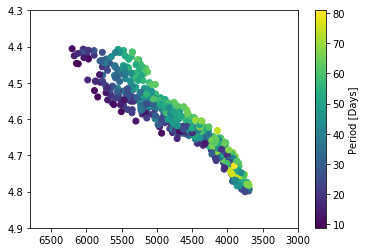

In [41]:
plt.scatter(df.teff, df.logg, c=df.prot)
plt.ylim(4.9, 4.3)
plt.xlim(6800, 3000)
plt.colorbar(label="Period [Days]")

Perturb the true parameters with some amount of noise.

In [45]:
teff_err = 50  # Kelvin
logg_err = .1  # dex
feh_err = .01  # dex
jmag_err = .01 # mags
hmag_err = .01  # mags
kmag_err = .01  # mags
parallax_err = .01  # milliarcseconds
prot_err = 1  # Days
BV_err = .01  # mags

teff = df.teff.values + np.random.randn()*teff_err
logg = df.logg.values + np.random.randn()*logg_err
feh = df.feh.values + np.random.randn()*feh_err
jmag = df.jmag.values + np.random.randn()*jmag_err
hmag = df.hmag.values + np.random.randn()*hmag_err
kmag = df.kmag.values + np.random.randn()*kmag_err
parallax = df.parallax.values + np.random.randn()*parallax_err
prot = df.prot.values + np.random.randn()*prot_err
BV = df.BV.values + np.random.randn()*BV_err

# teff_err = df.teff_err  # Kelvin
# logg_err = df.logg_err  # dex
# feh_err = df.feh_err  # dex
# jmag_err = df.jmag_err # mags
# hmag_err = df.hmag_err  # mags
# kmag_err = df.kmag_err  # mags
# parallax_err = df.parallax_err  # milliarcseconds
# prot_err = df.prot_err  # Days
# BV_err = df.BV_err  # mags

Create a dataframe from the observed data.

In [46]:
obs = pd.DataFrame(dict({"teff": teff, "teff_err": teff_err,
                         "logg": logg, "logg_err": logg_err,
                         "feh": feh, "feh_err": feh_err, 
                         "jmag": jmag, "jmag_err": jmag_err,
                         "hmag": hmag, "hmag_err": hmag_err,
                         "kmag": kmag, "kmag_err": kmag_err,
                         "parallax": parallax, "parallax_err": parallax_err, 
                         "prot": prot, "prot_err": prot_err,
                         "BV": BV, "BV_err": BV_err}))

In [50]:
mod, param_dict, p_init, args = setup(obs.iloc[0], df.iloc[0], gyro_only=False, iso_only=False)
print(p_init)
print(lnprob(p_init, *args))
print(lnprob(p_init + (np.random.randn(5)*.01), *args))

[ 0.          9.          0.         -0.69314718  0.01      ]
-19969795195.708015
-19657688083.422047


Loop over stars.

In [51]:
gyro_only, iso_only = False, False

N = len(df)
for i in tqdm.tqdm(range(N)):
    print(i, "of", N)
    
    np.random.seed(42)
    mod, param_dict, p_init, args = setup(obs.iloc[i], df.iloc[i], gyro_only=gyro_only, iso_only=iso_only)
    sampler = run_mcmc(obs.iloc[i], args, p_init, burnin=10000, production=20000)
    
    savedir = "simulation_results/iso_and_gyro"
    
    # Make the plots
#     truths = [np.log(df.mass.values[i]), df.age.values[i], df.feh.values[i],
#               np.log(df.d_kpc.values[i]), df.Av.values[i]]
    truths = [None, None, None, None, None]
    print("truths = ", truths)
    make_plots(sampler, i, truths, savedir)
    
    # Save the samples
    samples = sampler.flatchain
#     samples[:, 0] = np.exp(samples[:, 0])
#     samples[:, 3] = np.exp(samples[:, 3])
#     samples[:, 1] = (10**samples[:, 1])*1e-9
    
    print("Saving samples...")
    with h5py.File("{0}/{1}.h5".format(savedir, i), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples
    assert 0


  0%|          | 0/482 [00:00<?, ?it/s]

0 of 482
Burning in...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/ruthangus/projects/habitablezoning/code/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2



Production run...
truths =  [None, None, None, None, None]
Plotting age posterior
Plotting production chains...
Making corner plot...
Making linear corner plot...
Saving samples...


AssertionError: 

In [38]:
# i = 0
# truths = [np.log(df.mass.values[i]), df.age.values[i], df.feh.values[i],
#               np.log(df.d_kpc.values[i]), df.Av.values[i]]
# print("truths = ", truths)

In [ ]:
d_kpc = np.exp(samples[:, 3])
plt.hist(d_kpc)
plt.xlabel("Distance [kpc]")
med, std = np.median(d_kpc), np.std(d_kpc)
plt.axvline(med, color="k")
plt.axvline(med - std, color="k", linestyle="--")
plt.axvline(med + std, color="k", linestyle="--")
plt.axvline(df.d_kpc.values[0], color="tab:orange")
print(d_kpc[0])
print(df.d_kpc.values[0])

In [39]:
gyro_only, iso_only = False, True

N = len(df)
for i in tqdm.tqdm(range(N)):
    print(i, "of", N)
    
    np.random.seed(42)
    mod, param_dict, p_init, args = setup(obs.iloc[i], df.iloc[i], gyro_only=gyro_only, iso_only=iso_only)
    sampler = run_mcmc(obs.iloc[i], args, p_init, burnin=10000, production=20000)
    
    savedir = "simulation_results/iso_only"
    
    # Make the plots
#     truths = [np.log(df.mass.values[i]), df.age.values[i], df.feh.values[i],
#               np.log(df.d_kpc.values[i]), df.Av.values[i]]
    truths = [None, None, None, None, None]
    make_plots(sampler, i, truths, savedir)
    
    # Save the samples
    samples = sampler.flatchain
    
    print("Saving samples...")
    with h5py.File("{0}/{1}.h5".format(savedir, i), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples
    assert 0


  0%|          | 0/37 [00:00<?, ?it/s]

0 of 37
Burning in...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/ruthangus/projects/habitablezoning/code/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp



Production run...
Plotting age posterior
Plotting production chains...
Making corner plot...
Making linear corner plot...
Saving samples...


AssertionError: 

In [ ]:
gyro_only, iso_only = True, False

N = len(df)
for i in tqdm.tqdm(range(N)):
    print(i, "of", N)
    
    np.random.seed(42)
    mod, param_dict, p_init, args = setup(obs.iloc[i], df.iloc[i], gyro_only=gyro_only, iso_only=iso_only)
    sampler = run_mcmc(obs.iloc[i], args, p_init, burnin=10000, production=20000)
    
    savedir = "simulation_results/gyro_only"
    
    # Make the plots
    truths = [np.log(df.mass.values[i]), df.age.values[i], df.feh.values[i],
              np.log(df.d_kpc.values[i]), df.Av.values[i]]
    make_plots(sampler, i, truths, savedir)
    
    # Save the samples
    samples = sampler.flatchain
    
    print("Saving samples...")
    with h5py.File("{0}/{1}.h5".format(savedir, i), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples
    assert 0

Load the results.

In [ ]:
print(df.age)

In [ ]:
print(obs.iloc[0])
print("age = ", (10**df.age.values[0])*1e-9)

In [ ]:
plt.hist(df.age)

In [ ]:
iso_med, iso_std = [], []
Ns = 5
for star in range(Ns):
    fname = "samples/{0}__iso.h5".format(star)
    with h5py.File(fname, "r") as f:
        samples = f["samples"][...]
        iso_med.append(np.median(age_gyr))
        iso_std.append(np.std(age_gyr))